In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
raw = pd.read_csv("../data/fight_results.csv")
raw['date'] = pd.to_datetime(raw['date'])

In [3]:
# shuffle the order of fighers. UFC always has the winning figher as fighter 1
df = raw.copy()
df['fight_id'] = df.index
df['blue'] = np.random.choice(a=[1, 2], p=[0.5, 0.5], size=df.shape[0])
df['red'] = df['blue'].apply(lambda x: 1 if x == 2 else 2)
df['winner_colour'] = df['blue'].apply(lambda x: "blue" if x == 1 else "red")
df['blue'] = df.apply(lambda x: x['fighter_1_name'] if x['blue'] == 1 else x['fighter_2_name'], axis=1)
df['red'] = df.apply(lambda x: x['fighter_1_name'] if x['red'] == 1 else x['fighter_2_name'], axis=1)


# pivot longer
cols_to_pivot = ['fighter_1_name', 'fighter_2_name']

df_long = df.melt(
    value_vars=cols_to_pivot,
    id_vars=[i for i in df.columns if i not in cols_to_pivot],
    value_name="fighter_name", var_name="fighter_number"
)

df_long['fighter_number'] = df_long['fighter_number'].str.replace("_name", "")
df_long['colour'] = df_long.apply(lambda x: 'blue' if x['blue'] == x['fighter_name'] else 'red', axis=1)
df_long['opponent_name'] = df_long.apply(lambda x: x['blue'] if x['red'] == x['fighter_name'] else x['red'], axis=1)
df_long['str'] = df_long.apply(lambda x: x['fighter_1_str'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_str'], axis=1)
df_long['td'] = df_long.apply(lambda x: x['fighter_1_td'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_td'], axis=1)
df_long['sub'] = df_long.apply(lambda x: x['fighter_1_sub'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_sub'], axis=1)
df_long['pass'] = df_long.apply(lambda x: x['fighter_1_pass'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_pass'], axis=1)

df_long['winner'] = df_long.apply(lambda x: 1 if x['winner_colour'] == x['colour'] else 0, axis=1)
df_long['loser'] = df_long.apply(lambda x: 1 if x['winner_colour'] != x['colour'] else 0, axis=1)
df_long['blue_win'] = df_long['winner_colour'].apply(lambda x: 1 if x == 'blue' else 0)

df_long = df_long[['event_name', 'date', 'weight_class', 'win_method', 'win_round', 'win_time',
                   'fight_id', 'fighter_name', 'fighter_number', 'colour', 'str', 'td', 'sub', 'pass', 
                   'winner', 'loser', 'blue_win']]

df_long

,event_name,date,weight_class,win_method,win_round,win_time,fight_id,fighter_name,fighter_number,colour,str,td,sub,pass,winner,loser,blue_win
0,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Lightweight,"SUB, Guillotine, Choke",3,0:28,0,Charles Oliveira,fighter_1,red,43,0,2,0,1,0,0
1,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Welterweight,"KO/TKO, Punch",1,2:34,1,Gilbert Burns,fighter_1,blue,13,0,0,0,1,0,1
2,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Lightweight,"SUB, Rear, Naked, Choke",1,0:44,2,Renato Moicano,fighter_1,blue,1,1,1,1,1,0,1
3,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Light Heavyweight,U-DEC,3,5:00,3,Nikita Krylov,fighter_1,blue,45,3,0,4,1,0,1
4,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Lightweight,U-DEC,3,5:00,4,Francisco Trinaldo,fighter_1,blue,55,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,UFC_1-The_Beginning,1993-11-12,Open Weight,KO/TKO,1,0:59,5531,Kevin Rosier,fighter_2,blue,0,0,0,0,0,1,0
11068,UFC_1-The_Beginning,1993-11-12,Open Weight,"SUB, Heel, Hook",1,1:49,5532,Patrick Smith,fighter_2,red,4,0,0,0,0,1,1
11069,UFC_1-The_Beginning,1993-11-12,Open Weight,"SUB, Other",1,2:18,5533,Art Jimmerson,fighter_2,red,0,0,0,0,0,1,1
11070,UFC_1-The_Beginning,1993-11-12,Open Weight,KO/TKO,1,4:20,5534,Zane Frazier,fighter_2,blue,12,0,0,0,0,1,0


In [4]:
def win_method_binner(x):
    """Categorize win methods into bins."""
    if "DEC" in x:
        return "DEC"
    elif "TKO" in x:
        return "TKO"
    elif "SUB" in x:
        return "SUB"
    elif "Overturned" in x:
        return "Overturned"
    else:
        return x

In [5]:
# calculate running total stats for the fighers.
# Ideas for features:
# wins, loss, TKO, TKO received, days since last fight, height, weight, wing_span, win streak, loss streak, last fight time
df_long = df_long.sort_values(by=['fighter_name', 'date'])
df_long = df_long.reset_index(drop=True)
df_long['win_method_bin'] = df_long['win_method'].apply(win_method_binner)
df_long['num_fights'] = df_long.groupby('fighter_name')['event_name'].cumcount() + 1
df_long['wins'] = df_long.groupby('fighter_name')['winner'].cumsum()
df_long['losses'] = df_long.groupby('fighter_name')['loser'].cumsum()
df_long['days_since_last_fight'] = df_long.groupby('fighter_name')['date'].diff().dt.days.fillna(0)
df_long['tko_recieved'] = df_long.apply(lambda x: 1 if x['winner'] == 0 and x['win_method_bin'] == "TKO" else 0, axis=1)
df_long['total_tko_recieved'] = df_long.groupby('fighter_name')['tko_recieved'].cumsum()
df_long['fight_time'] = df_long.apply(lambda x: (x['win_round'] - 1) * 5 + float(x['win_time'][-2])/60 + float(x['win_time'][0]), axis=1)
df_long['total_octagon_time'] = df_long.groupby('fighter_name')['fight_time'].cumsum()
df_long['last_fight_time'] = df_long.groupby('fighter_name')['fight_time'].shift(periods=1).fillna(0)
df_long['last_fight_tko_received'] = df_long.groupby('fighter_name')['tko_recieved'].shift(periods=1).fillna(0).astype(int)
df_long['last_fight_win'] = df_long.groupby('fighter_name')['winner'].shift(periods=1).fillna(0).astype(int)
df_long['last_fight_loss'] = df_long.groupby('fighter_name')['loser'].shift(periods=1).fillna(0).astype(int)
# df_long['win_streak'] = np.NaN
# df_long['loss_streak'] = np.NaN


df_long.query("fighter_name == 'Conor McGregor'")

,event_name,date,weight_class,win_method,win_round,win_time,fight_id,fighter_name,fighter_number,colour,str,td,sub,pass,winner,loser,blue_win,win_method_bin,num_fights,wins,losses,days_since_last_fight,tko_recieved,total_tko_recieved,fight_time,total_octagon_time,last_fight_time,last_fight_tko_received,last_fight_win,last_fight_loss
2005,UFC_on_FUEL_TV_9-Mousasi_vs_Latifi,2013-04-06,Featherweight,"KO/TKO, Punches",1,1:07,3300,Conor McGregor,fighter_1,blue,21,0,0,0,1,0,1,TKO,1,1,0,0.0,0,0,1.000000,1.000000,0.000000,0,0,0
2006,UFC_Fight_Night-Shogun_vs_Sonnen,2013-08-17,Featherweight,U-DEC,3,5:00,3167,Conor McGregor,fighter_1,blue,53,4,0,6,1,0,1,DEC,2,2,0,133.0,0,0,15.000000,16.000000,1.000000,0,1,0
2007,UFC_Fight_Night-McGregor_vs_Brandao,2014-07-19,Featherweight,"KO/TKO, Punch",1,4:05,2724,Conor McGregor,fighter_1,blue,18,1,0,1,1,0,1,TKO,3,3,0,336.0,0,0,4.000000,20.000000,15.000000,0,1,0
2008,UFC_178-Johnson_vs_Cariaso,2014-09-27,Featherweight,"KO/TKO, Punch",1,1:46,2632,Conor McGregor,fighter_1,blue,9,0,0,0,1,0,1,TKO,4,4,0,70.0,0,0,1.066667,21.066667,4.000000,0,1,0
2009,UFC_Fight_Night-McGregor_vs_Siver,2015-01-18,Featherweight,"KO/TKO, Punch",2,1:54,2483,Conor McGregor,fighter_1,red,64,0,0,1,1,0,0,TKO,5,5,0,113.0,0,0,6.083333,27.150000,1.066667,0,1,0
2010,UFC_189-Mendes_vs_McGregor,2015-07-11,Featherweight,"KO/TKO, Punch",2,4:57,2258,Conor McGregor,fighter_1,blue,46,0,0,0,1,0,1,TKO,6,6,0,174.0,0,0,9.083333,36.233333,6.083333,0,1,0
2011,UFC_194-Aldo_vs_McGregor,2015-12-12,Featherweight,"KO/TKO, Punch",1,0:13,2048,Conor McGregor,fighter_1,red,5,0,0,0,1,0,0,TKO,7,7,0,154.0,0,0,0.016667,36.250000,9.083333,0,1,0
2012,UFC_196-McGregor_vs_Diaz,2016-03-05,Welterweight,"SUB, Rear, Naked, Choke",2,4:12,1947,Conor McGregor,fighter_2,blue,61,0,0,0,0,1,0,SUB,8,7,1,84.0,0,0,9.016667,45.266667,0.016667,0,1,0
2013,UFC_202-Diaz_vs_McGregor_2,2016-08-20,Welterweight,M-DEC,5,5:00,1742,Conor McGregor,fighter_1,blue,164,0,0,0,1,0,1,DEC,9,8,1,168.0,0,0,25.000000,70.266667,9.016667,0,0,1
2014,UFC_205-Alvarez_vs_McGregor,2016-11-12,Lightweight,"KO/TKO, Punches",2,3:04,1639,Conor McGregor,fighter_1,blue,32,0,0,0,1,0,1,TKO,10,9,1,84.0,0,0,8.000000,78.266667,25.000000,0,1,0


In [6]:
X_ = df_long.pivot_table(index=['fight_id', 'colour']).unstack()
X_ = X_[['wins', 'losses', 'total_octagon_time', 'total_tko_recieved', 'days_since_last_fight', 
         'last_fight_tko_received', 'last_fight_win', 'last_fight_loss', 'last_fight_time', 'blue_win']]
X_.columns = ['_'.join(col).strip() for col in X_.columns.values]
X_['blue_win'] =X_['blue_win_blue']
X_ = X_.drop(columns=['blue_win_blue', 'blue_win_red'])
X_ = X_.reset_index()
X_

,fight_id,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win
0,0,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0
1,1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1
2,2,6,3,3,4,74.366667,65.133333,2,1,266.0,287.0,1,0,0,0,1,1,0.083333,15.000000,1
3,3,8,3,5,2,80.516667,18.150000,1,1,182.0,133.0,0,1,0,0,1,1,15.000000,2.000000,1
4,4,15,10,6,7,247.333333,194.333333,0,2,119.0,357.0,0,0,1,1,0,0,15.000000,15.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,5531,1,1,1,0,4.116667,0.083333,1,0,0.0,0.0,0,0,1,0,0,0,4.033333,0.000000,0
5532,5532,1,0,0,1,1.066667,1.066667,0,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,1
5533,5533,3,0,0,1,3.166667,2.016667,0,0,0.0,0.0,0,0,1,0,0,0,0.083333,0.000000,1
5534,5534,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,0


In [7]:
# double check everything matches
df_long.query("fight_id == 0 or fight_id == 99").sort_values(by='fight_id')

,event_name,date,weight_class,win_method,win_round,win_time,fight_id,fighter_name,fighter_number,colour,str,td,sub,pass,winner,loser,blue_win,win_method_bin,num_fights,wins,losses,days_since_last_fight,tko_recieved,total_tko_recieved,fight_time,total_octagon_time,last_fight_time,last_fight_tko_received,last_fight_win,last_fight_loss
1577,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Lightweight,"SUB, Guillotine, Choke",3,0:28,0,Charles Oliveira,fighter_1,red,43,0,2,0,1,0,0,SUB,26,17,9,119.0,0,4,10.033333,162.000000,1.033333,0,1,0
6147,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Lightweight,"SUB, Guillotine, Choke",3,0:28,0,Kevin Lee,fighter_2,blue,41,2,0,2,0,1,0,SUB,17,11,6,133.0,0,1,10.033333,196.416667,2.066667,0,1,0
5770,UFC_Fight_Night-Edgar_vs_The_Korean_Zombie,2019-12-21,Middleweight,U-DEC,3,5:00,99,Junyong Park,fighter_1,blue,77,5,0,0,1,0,1,DEC,2,1,1,112.0,0,0,15.000000,24.050000,9.050000,0,0,1
6725,UFC_Fight_Night-Edgar_vs_The_Korean_Zombie,2019-12-21,Middleweight,U-DEC,3,5:00,99,Marc-Andre Barriault,fighter_2,red,51,0,0,0,0,1,1,DEC,3,0,3,147.0,0,0,15.000000,45.000000,15.000000,0,0,1


In [8]:
X_.query("fight_id == 0 or fight_id == 99")

,fight_id,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win
0,0,11,17,6,9,196.416667,162.0,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0
99,99,1,0,1,3,24.050000,45.0,0,0,112.0,147.0,0,0,0,0,1,1,9.050000,15.000000,1


In [9]:
X = X_.drop(columns='blue_win')
y = X_['blue_win'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1993)
train_fight_id = X_train['fight_id'].ravel()
test_fight_id = X_test['fight_id'].ravel()
X_train = X_train.drop(columns=['fight_id'])
X_test = X_test.drop(columns=['fight_id'])

cols_to_standard_scale_regex = "total_octagon_time|last_fight_time|wins|losses|days_since_last_fight|total_tko_recieved"
cols_to_standard_scale = X_train.filter(regex=cols_to_standard_scale_regex).columns

scaler = StandardScaler()
X_train[cols_to_standard_scale] = scaler.fit_transform(X_train[cols_to_standard_scale])
X_test[cols_to_standard_scale] = scaler.transform(X_test[cols_to_standard_scale])

X_train

,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red
2545,0.943307,-0.171794,-0.578675,0.390765,0.162435,-0.069995,-0.658310,-0.650369,-0.349317,0.626143,0,0,1,1,0,0,0.996460,-0.165588
268,-0.992777,-0.438052,-0.578675,-1.040424,-0.739028,-0.635883,-0.658310,-0.650369,-0.808792,0.657666,0,0,0,1,0,0,-1.201520,-0.458854
5482,-0.992777,0.094465,-0.578675,-0.086298,-0.980877,-0.896808,-0.658310,0.353057,-0.808792,1.445736,0,1,0,0,0,1,-1.201520,-1.035770
1879,3.709141,2.490795,1.827308,2.776081,3.726826,2.280808,0.335213,-0.650369,-0.086760,0.626143,0,0,1,1,0,0,0.996460,-0.595871
20,0.666723,-0.704311,0.864915,-0.086298,0.475111,-0.272570,0.335213,-0.650369,-0.119580,-0.125901,0,0,0,0,1,1,0.996460,0.981034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.666723,0.626983,0.864915,2.299018,-0.213295,0.362403,2.322258,1.356483,-0.382137,-0.414110,1,0,0,1,1,0,-0.605623,-1.170384
349,0.113557,2.757054,-1.059871,2.299018,-0.185079,3.132117,-0.658310,1.356483,0.110158,0.310915,0,1,1,0,0,1,-0.898687,0.836805
5215,-0.992777,-0.171794,-0.578675,-0.563361,-0.687203,-0.354040,0.335213,-0.650369,-0.808792,1.315142,0,0,0,0,0,1,-1.201520,-1.177596
225,-0.716194,-0.970570,0.383718,-0.086298,-0.443627,-0.718454,-0.658310,0.353057,0.110158,-0.035836,0,0,0,0,1,1,0.996460,0.981034


In [10]:
models = defaultdict(list)

def update_models(model_tracker, model, X_train, y_train, X_test, y_test, name, description):
    model_tracker['name'].append(name)
    model_tracker['description'].append(description)
    model_tracker['train_accuracy'].append(model.score(X_train, y_train))
    model_tracker['test_accuracy'].append(model.score(X_test, y_test))
    model_tracker['coef'].append(model.coef_.round(2)[0])
    model_tracker['model'].append(model)
    return model_tracker

In [11]:
lr1 = LogisticRegression().fit(X_train, y_train)
models = update_models(models, lr1, X_train, y_train, X_test, y_test, 
                       "lr (all)", "lr with all 4 fight stats")
print(pd.DataFrame(data=lr1.coef_, columns=X_train.columns).T)
pd.DataFrame(models)

                                     0
wins_blue                     3.424597
wins_red                     -2.856652
losses_blue                  -2.368176
losses_red                    2.301876
total_octagon_time_blue      -0.620439
total_octagon_time_red        0.271387
total_tko_recieved_blue      -0.593180
total_tko_recieved_red        0.434099
days_since_last_fight_blue    0.000468
days_since_last_fight_red    -0.038285
last_fight_tko_received_blue  0.417473
last_fight_tko_received_red  -0.277972
last_fight_win_blue          -0.210482
last_fight_win_red           -0.202421
last_fight_loss_blue          1.181843
last_fight_loss_red          -1.140347
last_fight_time_blue          0.081534
last_fight_time_red           0.016517


,name,description,train_accuracy,test_accuracy,coef,model
0,lr (all),lr with all 4 fight stats,0.898374,0.890794,"[3.42, -2.86, -2.37, 2.3, -0.62, 0.27, -0.59, ...","LogisticRegression(C=1.0, class_weight=None, d..."


In [12]:
X_train

,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red
2545,0.943307,-0.171794,-0.578675,0.390765,0.162435,-0.069995,-0.658310,-0.650369,-0.349317,0.626143,0,0,1,1,0,0,0.996460,-0.165588
268,-0.992777,-0.438052,-0.578675,-1.040424,-0.739028,-0.635883,-0.658310,-0.650369,-0.808792,0.657666,0,0,0,1,0,0,-1.201520,-0.458854
5482,-0.992777,0.094465,-0.578675,-0.086298,-0.980877,-0.896808,-0.658310,0.353057,-0.808792,1.445736,0,1,0,0,0,1,-1.201520,-1.035770
1879,3.709141,2.490795,1.827308,2.776081,3.726826,2.280808,0.335213,-0.650369,-0.086760,0.626143,0,0,1,1,0,0,0.996460,-0.595871
20,0.666723,-0.704311,0.864915,-0.086298,0.475111,-0.272570,0.335213,-0.650369,-0.119580,-0.125901,0,0,0,0,1,1,0.996460,0.981034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.666723,0.626983,0.864915,2.299018,-0.213295,0.362403,2.322258,1.356483,-0.382137,-0.414110,1,0,0,1,1,0,-0.605623,-1.170384
349,0.113557,2.757054,-1.059871,2.299018,-0.185079,3.132117,-0.658310,1.356483,0.110158,0.310915,0,1,1,0,0,1,-0.898687,0.836805
5215,-0.992777,-0.171794,-0.578675,-0.563361,-0.687203,-0.354040,0.335213,-0.650369,-0.808792,1.315142,0,0,0,0,0,1,-1.201520,-1.177596
225,-0.716194,-0.970570,0.383718,-0.086298,-0.443627,-0.718454,-0.658310,0.353057,0.110158,-0.035836,0,0,0,0,1,1,0.996460,0.981034


## Deep dive into results

In [13]:
X_train.columns

Index(['wins_blue', 'wins_red', 'losses_blue', 'losses_red',
       'total_octagon_time_blue', 'total_octagon_time_red',
       'total_tko_recieved_blue', 'total_tko_recieved_red',
       'days_since_last_fight_blue', 'days_since_last_fight_red',
       'last_fight_tko_received_blue', 'last_fight_tko_received_red',
       'last_fight_win_blue', 'last_fight_win_red', 'last_fight_loss_blue',
       'last_fight_loss_red', 'last_fight_time_blue', 'last_fight_time_red'],
      dtype='object')

In [14]:
lr1.predict(X_train)

array([1, 0, 0, ..., 0, 1, 1])

In [15]:
X_

,fight_id,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win
0,0,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0
1,1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1
2,2,6,3,3,4,74.366667,65.133333,2,1,266.0,287.0,1,0,0,0,1,1,0.083333,15.000000,1
3,3,8,3,5,2,80.516667,18.150000,1,1,182.0,133.0,0,1,0,0,1,1,15.000000,2.000000,1
4,4,15,10,6,7,247.333333,194.333333,0,2,119.0,357.0,0,0,1,1,0,0,15.000000,15.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,5531,1,1,1,0,4.116667,0.083333,1,0,0.0,0.0,0,0,1,0,0,0,4.033333,0.000000,0
5532,5532,1,0,0,1,1.066667,1.066667,0,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,1
5533,5533,3,0,0,1,3.166667,2.016667,0,0,0.0,0.0,0,0,1,0,0,0,0.083333,0.000000,1
5534,5534,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,0


In [16]:
results_train = pd.DataFrame(data=X_train.copy(), columns=X_train.columns)
results_train['fight_id'] = train_fight_id
results_train['blue_win'] = y_train
results_train['prediction'] = lr1.predict(X_train)
results_train['prediction_prob_win'] = lr1.predict_proba(X_train)[:,1]
results_train['split'] = 'train'

results_test = pd.DataFrame(data=X_test.copy(), columns=X_test.columns)
results_test['fight_id'] = test_fight_id
results_test['blue_win'] = y_test
results_test['prediction'] = lr1.predict(X_test)
results_test['prediction_prob_win'] = lr1.predict_proba(X_test)[:,1]
results_test['split'] = 'test'

results = pd.concat([results_train, results_test])
results['correct'] = results.apply(lambda x: 1 if x['blue_win'] == x['prediction'] else 0, axis=1)


df_final = pd.merge(df, 
                   results[['fight_id', 'prediction', 'prediction_prob_win', 'correct', 'split']], 
                   how='left', left_on='fight_id', right_on='fight_id')

df_final['predicted_winner'] = df_final.apply(lambda x: x['blue'] if x['prediction'] == 1 else x['red'] , axis=1)

df_final = pd.merge(df_final,
                    X_,
                    how='left', left_on='fight_id', right_on='fight_id')

df_final = df_final[['event_name', 'date', 'fighter_1_name', 'fighter_2_name',
                     'win_method', 'winner',
                     'wins_blue', 'wins_red', 'losses_blue', 'losses_red',
                     'total_octagon_time_blue', 'total_octagon_time_red',
                     'total_tko_recieved_blue', 'total_tko_recieved_red',
                     'days_since_last_fight_blue', 'days_since_last_fight_red',
                     'last_fight_tko_received_blue', 'last_fight_tko_received_red',
                     'last_fight_win_blue', 'last_fight_win_red', 'last_fight_loss_blue',
                     'last_fight_loss_red', 'last_fight_time_blue', 'last_fight_time_red',
                     'fight_id', 'blue', 'red', 'winner_colour', 'prediction',
                     'prediction_prob_win', 'correct', 'split', 'predicted_winner']]

df_final

,event_name,date,fighter_1_name,fighter_2_name,win_method,winner,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,fight_id,blue,red,winner_colour,prediction,prediction_prob_win,correct,split,predicted_winner
0,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Charles Oliveira,Kevin Lee,"SUB, Guillotine, Choke",fighter_1,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0,Kevin Lee,Charles Oliveira,red,0,0.475678,1,train,Charles Oliveira
1,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Gilbert Burns,Demian Maia,"KO/TKO, Punch",fighter_1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1,Gilbert Burns,Demian Maia,blue,1,0.944968,1,train,Gilbert Burns
2,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Renato Moicano,Damir Hadzovic,"SUB, Rear, Naked, Choke",fighter_1,6,3,3,4,74.366667,65.133333,2,1,266.0,287.0,1,0,0,0,1,1,0.083333,15.000000,2,Renato Moicano,Damir Hadzovic,blue,1,0.972719,1,train,Renato Moicano
3,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Nikita Krylov,Johnny Walker,U-DEC,fighter_1,8,3,5,2,80.516667,18.150000,1,1,182.0,133.0,0,1,0,0,1,1,15.000000,2.000000,3,Nikita Krylov,Johnny Walker,blue,1,0.686517,1,train,Nikita Krylov
4,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,Francisco Trinaldo,John Makdessi,U-DEC,fighter_1,15,10,6,7,247.333333,194.333333,0,2,119.0,357.0,0,0,1,1,0,0,15.000000,15.000000,4,Francisco Trinaldo,John Makdessi,blue,1,0.998137,1,train,Francisco Trinaldo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,UFC_1-The_Beginning,1993-11-12,Gerard Gordeau,Kevin Rosier,KO/TKO,fighter_1,1,1,1,0,4.116667,0.083333,1,0,0.0,0.0,0,0,1,0,0,0,4.033333,0.000000,5531,Kevin Rosier,Gerard Gordeau,red,0,0.148273,1,train,Gerard Gordeau
5532,UFC_1-The_Beginning,1993-11-12,Ken Shamrock,Patrick Smith,"SUB, Heel, Hook",fighter_1,1,0,0,1,1.066667,1.066667,0,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,5532,Ken Shamrock,Patrick Smith,blue,1,0.884813,1,train,Ken Shamrock
5533,UFC_1-The_Beginning,1993-11-12,Royce Gracie,Art Jimmerson,"SUB, Other",fighter_1,3,0,0,1,3.166667,2.016667,0,0,0.0,0.0,0,0,1,0,0,0,0.083333,0.000000,5533,Royce Gracie,Art Jimmerson,blue,1,0.976001,1,train,Royce Gracie
5534,UFC_1-The_Beginning,1993-11-12,Kevin Rosier,Zane Frazier,KO/TKO,fighter_1,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,5534,Zane Frazier,Kevin Rosier,red,0,0.074847,1,test,Kevin Rosier


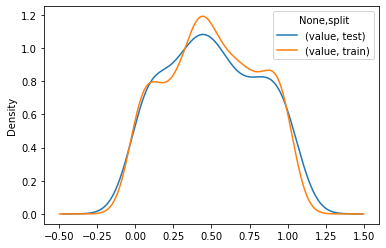

In [17]:
(df_final
 .query('correct == 0')
 .melt(id_vars='split', value_vars='prediction_prob_win')
 .drop(columns='variable')
 .pivot(columns='split')
 .plot.kde()
);

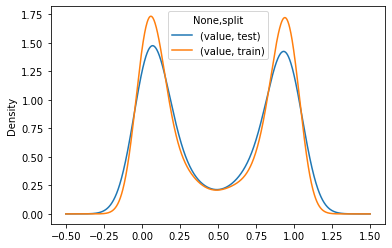

In [18]:
(df_final
 .query('correct == 1')
 .melt(id_vars='split', value_vars='prediction_prob_win')
 .drop(columns='variable')
 .pivot(columns='split')
 .plot.kde()
);

In [19]:
(df_final
 .query('correct == 0 and prediction_prob_win > 0.9')
 .sort_values(by='prediction_prob_win', ascending=False)
 .head()
)

,event_name,date,fighter_1_name,fighter_2_name,win_method,winner,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,fight_id,blue,red,winner_colour,prediction,prediction_prob_win,correct,split,predicted_winner
427,UFC_237-Namajunas_vs_Andrade,2019-05-11,Jared Cannonier,Anderson Silva,"KO/TKO, Kick",fighter_1,18,5,6,4,246.716667,72.350000,3,2,91.0,189.0,0,0,0,1,1,0,15.000000,5.050000,427,Anderson Silva,Jared Cannonier,red,1,0.999837,0,train,Anderson Silva
3197,UFC_162-Silva_vs_Weidman,2013-07-06,Chris Weidman,Anderson Silva,"KO/TKO, Punch",fighter_1,16,6,1,0,141.633333,48.150000,1,0,266.0,360.0,0,0,1,1,0,0,4.066667,6.050000,3197,Anderson Silva,Chris Weidman,red,1,0.999215,0,train,Anderson Silva
1863,UFC_Fight_Night-Almeida_vs_Garbrandt,2016-05-29,Jeremy Stephens,Renan Barao,U-DEC,fighter_1,8,12,3,11,150.366667,281.533333,2,1,309.0,169.0,1,0,0,0,1,1,15.050000,15.000000,1863,Renan Barao,Jeremy Stephens,red,1,0.998726,0,train,Renan Barao
1074,UFC_Fight_Night-Stephens_vs_Choi,2018-01-14,Jeremy Stephens,Dooho Choi,"KO/TKO, Punch",fighter_1,3,14,2,13,25.183333,333.583333,1,1,400.0,127.0,0,0,0,1,1,0,15.000000,15.000000,1074,Dooho Choi,Jeremy Stephens,red,1,0.998398,0,train,Dooho Choi
4143,UFC_116-Lesnar_vs_Carwin,2010-07-03,Chris Lytle,Matt Brown,"SUB, Armbar",fighter_1,4,8,3,9,56.283333,169.233333,0,2,98.0,133.0,0,0,0,1,1,0,8.050000,1.066667,4143,Matt Brown,Chris Lytle,red,1,0.998074,0,test,Matt Brown


It looks like for a lot of the cases, it was due to a knockout which makes sense. How accurate is the model for decisions?

In [20]:
n_dec = df_final['win_method'].str.contains("DEC").sum()
print(n_dec)
df_final[df_final['win_method'].str.contains("DEC")]['correct'].sum()/n_dec

2493


0.8844765342960289

Surprisingly, the model does not do better on decisions.

In [21]:
n_tko = df_final['win_method'].str.contains("TKO").sum()
print(n_tko)
df_final[df_final['win_method'].str.contains("TKO")]['correct'].sum()/n_tko

1837


0.9020141535111595

In [22]:
n_sub = df_final['win_method'].str.contains("SUB").sum()
print(n_sub)
df_final[df_final['win_method'].str.contains("SUB")]['correct'].sum()/n_sub

1135


0.9162995594713657

## How would the model perform if it was trained after each event?

In [23]:
event_names = df_long.sort_values(by='date')['event_name'].unique()
event_to_id_mapper = pd.DataFrame(data={'event_name': event_names, 'event_id': np.arange(1, len(event_names) + 1)})
event_to_id_mapper.index = event_to_id_mapper['event_id'].values
event_to_id_mapper

,event_name,event_id
1,UFC_1-The_Beginning,1
2,UFC_2-No_Way_Out,2
3,UFC_3-The_American_Dream,3
4,UFC_4-Revenge_of_the_Warriors,4
5,UFC_5-The_Return_of_the_Beast,5
...,...,...
506,UFC_Fight_Night-Anderson_vs_Blachowicz,506
507,UFC_Fight_Night-Felder_vs_Hooker,507
508,UFC_Fight_Night-Benavidez_vs_Figueiredo,508
509,UFC_248-Adesanya_vs_Romero,509


In [24]:
X_.sort_values(by='fight_id')

,fight_id,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win
0,0,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0
1,1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1
2,2,6,3,3,4,74.366667,65.133333,2,1,266.0,287.0,1,0,0,0,1,1,0.083333,15.000000,1
3,3,8,3,5,2,80.516667,18.150000,1,1,182.0,133.0,0,1,0,0,1,1,15.000000,2.000000,1
4,4,15,10,6,7,247.333333,194.333333,0,2,119.0,357.0,0,0,1,1,0,0,15.000000,15.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,5531,1,1,1,0,4.116667,0.083333,1,0,0.0,0.0,0,0,1,0,0,0,4.033333,0.000000,0
5532,5532,1,0,0,1,1.066667,1.066667,0,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,1
5533,5533,3,0,0,1,3.166667,2.016667,0,0,0.0,0.0,0,0,1,0,0,0,0.083333,0.000000,1
5534,5534,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,0


In [25]:
print(df_long.shape)
df_long = df_long.merge(event_to_id_mapper, on="event_name", how='left')
print(df_long.shape)
print(df.shape)
df = df.merge(event_to_id_mapper, on="event_name", how='left')
print(df.shape)
print(X_.shape)
X_ = pd.merge(X_.copy(), 
              df_long[['fight_id', 'event_id']], 
              left_on="fight_id", right_on='fight_id', how='left')
# X_ = X_.merge(df_long[['fight_id', 'event_id']], on="fight_id", how='left')
print(X_.shape)

(11072, 30)
(11072, 31)
(5536, 22)
(5536, 23)
(5536, 20)
(11072, 21)


In [26]:
X_.sort_values(by='fight_id')

,fight_id,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win,event_id
0,0,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0,510
1,0,11,17,6,9,196.416667,162.000000,1,4,133.0,119.0,0,0,1,1,0,0,2.066667,1.033333,0,510
2,1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1,510
3,1,11,22,2,10,124.450000,386.783333,1,2,168.0,140.0,0,0,1,1,0,0,15.000000,13.083333,1,510
4,2,6,3,3,4,74.366667,65.133333,2,1,266.0,287.0,1,0,0,0,1,1,0.083333,15.000000,1,510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,5533,3,0,0,1,3.166667,2.016667,0,0,0.0,0.0,0,0,1,0,0,0,0.083333,0.000000,1,1
11068,5534,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,0,1
11069,5534,0,1,1,0,4.033333,4.033333,1,0,0.0,0.0,0,0,0,0,0,0,0.000000,0.000000,0,1
11070,5535,0,2,1,0,0.033333,0.116667,1,0,0.0,0.0,0,0,0,1,0,0,0.000000,0.083333,0,1


In [27]:
%time
results = defaultdict(list)
train_events = []
# for i in np.arange(1, max(event_to_id_mapper['event_id'])):
for i in np.arange(1, 5):
    train_events.append(i)
    test_event = i + 1
    
    # preprocess data
    X = X_.copy()
    # filter out first time fighters
#     X = X.query('wins_blue + losses_red > 0 and wins_red + losses_red > 0')
    #
    y = X['blue_win'].ravel()
    X_train = X.query('event_id in @train_events').drop(columns=['blue_win', 'event_id', 'fight_id'])
    X_test =  X.query('event_id == @test_event').drop(columns=['blue_win', 'event_id'])
    test_fight_id = X_test['fight_id']
    X_test = X_test.drop(columns='fight_id')
    y_train = X.query('event_id in @train_events')['blue_win'].ravel()
    y_test = X.query('event_id == @test_event')['blue_win'].ravel()
    cols_to_standard_scale_regex = "total_octagon_time|last_fight_time|wins|losses|days_since_last_fight|total_tko_recieved"
    cols_to_standard_scale = X_train.filter(regex=cols_to_standard_scale_regex).columns
    scaler = StandardScaler()
    X_train[cols_to_standard_scale] = scaler.fit_transform(X_train[cols_to_standard_scale])
    X_test[cols_to_standard_scale] = scaler.transform(X_test[cols_to_standard_scale])
    

    # model
    lr = LogisticRegression().fit(X_train, y_train)
    
    # results
    results['num_train_events'].append(i)
    results['num_train_fights'].append(X_train.shape[0])
    results['num_test_fights'].append(X_test.shape[0])
    results['train_accuracy'].append(lr.score(X_train, y_train))
    results['test_accuracy'].append(lr.score(X_test, y_test))
    results['coef'].append(lr.coef_.round(2)[0])
    
    # save the detailed results
    results_test = pd.DataFrame(data=X_test.copy(), columns=X_test.columns)
    results_test['fight_id'] = test_fight_id
    results_test['blue_win'] = y_test
    results_test['prediction'] = lr1.predict(X_test)
    results_test['prediction_prob_win'] = lr1.predict_proba(X_test)[:,1]
    results_test['split'] = 'test'
    results_test['correct'] = results_test.apply(lambda x: 1 if x['blue_win'] == x['prediction'] else 0, axis=1)
    df_final = pd.merge(df.query('event_id == @test_event'), 
                       results_test[['fight_id', 'prediction', 'prediction_prob_win', 'correct', 'split']], 
                       how='left', left_on='fight_id', right_on='fight_id')
    df_final['predicted_winner'] = df_final.apply(lambda x: x['blue'] if x['prediction'] == 1 else x['red'] , axis=1)
    df_final = pd.merge(df_final,
                        X_,
                        how='left', left_on='fight_id', right_on='fight_id')
    df_final = df_final[['event_name', 'date', 'fighter_1_name', 'fighter_2_name',
                         'win_method', 'winner',
                         'wins_blue', 'wins_red', 'losses_blue', 'losses_red',
                         'total_octagon_time_blue', 'total_octagon_time_red',
                         'total_tko_recieved_blue', 'total_tko_recieved_red',
                         'days_since_last_fight_blue', 'days_since_last_fight_red',
                         'last_fight_tko_received_blue', 'last_fight_tko_received_red',
                         'last_fight_win_blue', 'last_fight_win_red', 'last_fight_loss_blue',
                         'last_fight_loss_red', 'last_fight_time_blue', 'last_fight_time_red',
                         'fight_id', 'blue', 'red', 'winner_colour', 'prediction',
                         'prediction_prob_win', 'correct', 'split', 'predicted_winner']]

    results['details'].append(df_final)


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [28]:
results_df = pd.DataFrame(results)
results_df['test_accuracy_running_mean'] = results_df['test_accuracy'].cumsum() / results_df['num_train_events']
results_df['test_accuracy_rolling'] = results_df[['test_accuracy']].rolling(10).mean()
results_df

,num_train_events,num_train_fights,num_test_fights,train_accuracy,test_accuracy,coef,details,test_accuracy_running_mean,test_accuracy_rolling
0,1,16,30,1.0,0.866667,"[0.49, -0.19, -0.96, 0.96, -0.04, 0.08, -0.42,...",event_name date fighter_1_name...,0.866667,NaN
1,2,46,12,1.0,1.000000,"[0.7, -0.65, -1.04, 1.25, 0.17, 0.11, -0.91, 0...",event_name date fighte...,0.933333,NaN
2,3,58,20,1.0,1.000000,"[0.64, -0.73, -0.94, 1.42, 0.24, 0.22, -1.03, ...",event_name date ...,0.955556,NaN
3,4,78,20,1.0,0.800000,"[0.67, -0.66, -1.06, 1.67, 0.27, 0.14, -1.07, ...",event_name date f...,0.916667,NaN


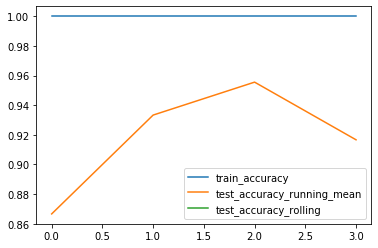

In [29]:
results_df[['train_accuracy', 
#             'test_accuracy',
            'test_accuracy_running_mean', 
            'test_accuracy_rolling']].plot.line();

In [30]:
print("Mean:", results_df.test_accuracy.mean().round(2), "\n")
print("Quantiles:", results_df.test_accuracy.quantile([0.25, 0.5, 0.75, 0.99]), sep="\n")

Mean: 0.92 

Quantiles:
0.25    0.850000
0.50    0.933333
0.75    1.000000
0.99    1.000000
Name: test_accuracy, dtype: float64


In [31]:
results_df['details'][1]

,event_name,date,fighter_1_name,fighter_2_name,win_method,winner,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,fight_id,blue,red,winner_colour,prediction,prediction_prob_win,correct,split,predicted_winner
0,UFC_3-The_American_Dream,1994-09-09,Steve Jennum,Harold Howard,"KO/TKO, Punches",fighter_1,1,1,1,0,1.100000,1.033333,1,0,0.0,0.0,0,0,1,0,0,0,0.066667,0.0,5507,Harold Howard,Steve Jennum,red,0,0.001896,1,test,Steve Jennum
1,UFC_3-The_American_Dream,1994-09-09,Steve Jennum,Harold Howard,"KO/TKO, Punches",fighter_1,1,1,1,0,1.100000,1.033333,1,0,0.0,0.0,0,0,1,0,0,0,0.066667,0.0,5507,Harold Howard,Steve Jennum,red,0,0.001896,1,test,Steve Jennum
2,UFC_3-The_American_Dream,1994-09-09,Steve Jennum,Harold Howard,"KO/TKO, Punches",fighter_1,1,1,1,0,1.100000,1.033333,1,0,0.0,0.0,0,0,1,0,0,0,0.066667,0.0,5507,Harold Howard,Steve Jennum,red,0,0.001896,1,test,Steve Jennum
3,UFC_3-The_American_Dream,1994-09-09,Steve Jennum,Harold Howard,"KO/TKO, Punches",fighter_1,1,1,1,0,1.100000,1.033333,1,0,0.0,0.0,0,0,1,0,0,0,0.066667,0.0,5507,Harold Howard,Steve Jennum,red,0,0.001896,1,test,Steve Jennum
4,UFC_3-The_American_Dream,1994-09-09,Ken Shamrock,Felix Lee Mitchell,"SUB, Rear, Naked, Choke",fighter_1,2,0,1,1,5.200000,4.050000,0,0,301.0,0.0,0,0,0,0,1,0,0.083333,0.0,5508,Ken Shamrock,Felix Lee Mitchell,blue,1,0.983581,1,test,Ken Shamrock
5,UFC_3-The_American_Dream,1994-09-09,Ken Shamrock,Felix Lee Mitchell,"SUB, Rear, Naked, Choke",fighter_1,2,0,1,1,5.200000,4.050000,0,0,301.0,0.0,0,0,0,0,1,0,0.083333,0.0,5508,Ken Shamrock,Felix Lee Mitchell,blue,1,0.983581,1,test,Ken Shamrock
6,UFC_3-The_American_Dream,1994-09-09,Ken Shamrock,Felix Lee Mitchell,"SUB, Rear, Naked, Choke",fighter_1,2,0,1,1,5.200000,4.050000,0,0,301.0,0.0,0,0,0,0,1,0,0.083333,0.0,5508,Ken Shamrock,Felix Lee Mitchell,blue,1,0.983581,1,test,Ken Shamrock
7,UFC_3-The_American_Dream,1994-09-09,Ken Shamrock,Felix Lee Mitchell,"SUB, Rear, Naked, Choke",fighter_1,2,0,1,1,5.200000,4.050000,0,0,301.0,0.0,0,0,0,0,1,0,0.083333,0.0,5508,Ken Shamrock,Felix Lee Mitchell,blue,1,0.983581,1,test,Ken Shamrock
8,UFC_3-The_American_Dream,1994-09-09,Royce Gracie,Kimo Leopoldo,"SUB, Armbar",fighter_1,8,0,0,1,15.300000,4.066667,0,0,182.0,0.0,0,0,1,0,0,0,5.000000,0.0,5509,Royce Gracie,Kimo Leopoldo,blue,1,1.000000,1,test,Royce Gracie
9,UFC_3-The_American_Dream,1994-09-09,Royce Gracie,Kimo Leopoldo,"SUB, Armbar",fighter_1,8,0,0,1,15.300000,4.066667,0,0,182.0,0.0,0,0,1,0,0,0,5.000000,0.0,5509,Royce Gracie,Kimo Leopoldo,blue,1,1.000000,1,test,Royce Gracie
